In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Read the saved CSV files back into a DataFrames
atp_df = pd.read_csv('/content/drive/MyDrive/Stats/Code/atp_tennis.csv')

In [ ]:
# Display the first 5 rows of the DataFrame
atp_df.head()

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,Score,Comment
0,Brisbane International,2024-12-29,ATP250,Outdoor,Hard,1st Round,3,Vukic A.,Goffin D.,Vukic A.,68,52,778,1037,2.00,1.80,6-2 6-3,Completed
1,Brisbane International,2024-12-30,ATP250,Outdoor,Hard,1st Round,3,O Connell C.,Michelsen A.,Michelsen A.,64,41,795,1245,2.75,1.44,4-6 6-4 6-7,Completed
2,Brisbane International,2024-12-30,ATP250,Outdoor,Hard,1st Round,3,Bonzi B.,Tabilo A.,Bonzi B.,75,23,730,1943,1.67,2.20,6-7 7-6 6-4,Completed
3,Brisbane International,2024-12-30,ATP250,Outdoor,Hard,1st Round,3,Rinderknech A.,Nishioka Y.,Nishioka Y.,59,69,927,776,2.50,1.53,3-6 4-6,Completed
4,Brisbane International,2024-12-30,ATP250,Outdoor,Hard,1st Round,3,Thompson J.,Berrettini M.,Thompson J.,26,34,1745,1380,2.63,1.50,3-6 6-3 6-4,Completed


In [ ]:
# Set the time format for date conversion
timefmt = "%Y-%m-%d"
# Convert the 'Date' column to datetime objects using the specified format
atp_df['Date'] = pd.to_datetime(atp_df['Date'], format=timefmt)
# Filter the DataFrame based on 'Surface' being 'Hard', no missing values, and excluding 'Draper J.'
df_filter = atp_df.loc[(atp_df.notna().all(axis=1))
].copy()

In [ ]:
# Define a list of the current ATP top 8 players
current_rank = ['Sinner J.', 'Alcaraz C.', 'Zverev A.', 'Fritz T.', 'Shelton B.', 'De Minaur A.', 'Auger-Aliassime F.', 'Musetti L.']
# Filter the DataFrame to include only matches where at least one of the top 4 players is participating
df_filter = atp_df.loc[
    (atp_df["Player_1"].isin(current_rank))
    | (atp_df["Player_2"].isin(current_rank))
].copy()

In [ ]:
df_filter.to_csv('all.csv', index=False)

In [ ]:
# Define a function to parse the score string and extract games won by each player in each set
def parse_score(score_string):
    # Split the score string into individual set scores
    set_scores = score_string.split()
    player_1_games = []
    player_2_games = []

    # Iterate through each set score
    for set_score in set_scores:
        try:
            # Split the set score and convert games to integers
            games = set_score.split('-')
            if len(games) == 2:
                # Convert game scores to integers, handling cases where they might not be digits
                game1 = int(games[0]) if games[0].isdigit() else 0
                game2 = int(games[1]) if games[1].isdigit() else 0
                player_1_games.append(game1)
                player_2_games.append(game2)
            else:
                # Handle unexpected split results (e.g., scores without a hyphen) by appending 0 games
                player_1_games.append(0)
                player_2_games.append(0)
        except ValueError:
            # Handle cases where conversion to int fails by appending 0 games
            player_1_games.append(0)
            player_2_games.append(0)
        except AttributeError:
             # Handle potential None or non-string types in set_score by appending 0 games
            player_1_games.append(0)
            player_2_games.append(0)


    # Return the lists of games won by each player
    return player_1_games, player_2_games

In [ ]:
# Apply the modified parse_score function to the 'Score' column and create 'P1_sets' and 'P2_sets' columns
df_filter[['P1_sets', 'P2_sets']] = df_filter['Score'].apply(parse_score).apply(pd.Series)


In [ ]:
# Filter the DataFrame to get matches where Jannik Sinner is participating
sinner_df = df_filter.loc[(df_filter["Player_1"] == 'Sinner J.') | (df_filter["Player_2"] == 'Sinner J.')]

# Filter the DataFrame to get matches where Carlos Alcaraz is participating
alcaraz_df = df_filter.loc[ (df_filter["Player_1"] == 'Alcaraz C.') | (df_filter["Player_2"] == 'Alcaraz C.')]

# Filter the DataFrame to get matches where Taylor Fritz is participating
fritz_df = df_filter.loc[ (df_filter["Player_1"] == 'Fritz T.') | (df_filter["Player_2"] == 'Fritz T.')]

# Filter the DataFrame to get matches where Alexander Zverev is participating
zverev_df = df_filter.loc[(df_filter["Player_1"] == 'Zverev A.') | (df_filter["Player_2"] == 'Zverev A.')]

# Filter the DataFrame to get matches where Ben Shelton is participating
shelton_df = df_filter.loc[(df_filter["Player_1"] == 'Shelton B.') | (df_filter["Player_2"] == 'Shelton B.')]

# Filter the DataFrame to get matches where Alex de Minaur is participating
adm_df = df_filter.loc[(df_filter["Player_1"] == 'De Minaur A.') | (df_filter["Player_2"] == 'De Minaur A.')]

# Filter the DataFrame to get matches where Felix Auger-Aliassime is participating
faa_df = df_filter.loc[ (df_filter["Player_1"] == 'Auger-Aliassime F.') | (df_filter["Player_2"] == 'Auger-Aliassime F.')]

# Filter the DataFrame to get matches where Lorenzo Musetti is participating
musetti_df = df_filter.loc[(df_filter["Player_1"] == 'Musetti L.') | (df_filter["Player_2"] == 'Musetti L.')]


In [ ]:
# Define a function to calculate various performance metrics for a player
def performance(df, player):
  total_sets = 0
  sets_won = 0
  bagels_del = 0
  breadsticks_del = 0
  total_tiebreaks = 0
  tiebreaks_won = 0
  matchwon_after_losingfirst = 0
  lost_firstset = 0

  for index, row in df.iterrows():
    # Determine which player is the specified player and get their set scores and opponent's scores
    if row['Player_1'] == player:
      player_scores = row['P1_sets']
      opponent_scores = row['P2_sets']
    elif row['Player_2'] == player:
      player_scores = row['P2_sets']
      opponent_scores = row['P1_sets']

    # Add the number of sets in the current match to the total sets
    total_sets += len(player_scores)

    # Check if the player lost the first set
    if opponent_scores[0] > player_scores[0]:
      lost_firstset += 1
      # Check if the player won the match after losing the first set
      if player in str(row['Winner']):
        matchwon_after_losingfirst += 1

    for i in range(len(player_scores)):
      player_set_score = player_scores[i]
      opponent_set_score = opponent_scores[i]

      # Check if the player won the set
      if player_set_score > opponent_set_score:
        sets_won += 1

      # Check if the player delivered a bagel (won the set 6-0)
      if player_set_score == 6 and opponent_set_score == 0:
        bagels_del += 1
      # Check if the player delivered a breadstick (won the set 6-1)
      if player_set_score == 6 and opponent_set_score == 1:
        breadsticks_del += 1

      # Check if the set was a tiebreak and if the player won the tiebreak
      if player_set_score == 7 and opponent_set_score == 6:
        total_tiebreaks += 1
        tiebreaks_won += 1
      elif player_set_score == 6 and opponent_set_score == 7:
        total_tiebreaks += 1

  # Calculate performance percentages, handling division by zero
  set_win_per = (sets_won / total_sets) * 100 if total_sets > 0 else 0
  bagels_del_per = (bagels_del / total_sets) * 100 if total_sets > 0 else 0
  breadsticks_del_per = (breadsticks_del / total_sets) * 100 if total_sets > 0 else 0
  tiebreak_win_per = (tiebreaks_won / total_tiebreaks) * 100 if total_tiebreaks > 0 else 0

  # Return the calculated performance percentages
  return set_win_per, bagels_del_per, breadsticks_del_per, tiebreak_win_per

In [ ]:
# Count total sets, matches, tours
def count_all(df, player):
  total_sets = 0

  total_matches = len(df)

  for index, row in df.iterrows():
    # Determine which player is the specified player and get their set scores and opponent's scores
    if row['Player_1'] == player:
      player_scores = row['P1_sets']
      opponent_scores = row['P2_sets']
    elif row['Player_2'] == player:
      player_scores = row['P2_sets']
      opponent_scores = row['P1_sets']

    # Add the number of sets in the current match to the total sets
    total_sets += len(player_scores)

    total_tour = len(df['Tournament'].unique())


  return total_sets, total_matches, total_tour

In [ ]:
s_sets, s_matches, s_tours = count_all(sinner_df, 'Sinner J.')
a_sets, a_matches, a_tours = count_all(alcaraz_df, 'Alcaraz C.')
f_sets, f_matches, f_tours = count_all(fritz_df, 'Fritz T.')
z_sets, z_matches, z_tours = count_all(zverev_df, 'Zverev A.')
sb_sets, sb_matches, sb_tours = count_all(shelton_df, 'Shelton B.')
adm_sets, adm_matches, adm_tours = count_all(adm_df, 'De Minaur A.')
faa_sets, faa_matches, faa_tours = count_all(faa_df, 'Auger-Aliassime F.')
m_sets, m_matches, m_tours = count_all(musetti_df, 'Musetti L.')

print(f"Sinner's Total Sets: {s_sets}, Total Matches: {s_matches}, Total Tours: {s_tours}")
print(f"Alcaraz's Total Sets: {a_sets}, Total Matches: {a_matches}, Total Tours: {a_tours}")
print(f"Fritz's Total Sets: {f_sets}, Total Matches: {f_matches}, Total Tours: {f_tours}")
print(f"Zverev's Total Sets: {z_sets}, Total Matches: {z_matches}, Total Tours: {z_tours}")
print(f"Shelton's Total Sets: {sb_sets}, Total Matches: {sb_matches}, Total Tours: {sb_tours}")
print(f"De Minaur's Total Sets: {adm_sets}, Total Matches: {adm_matches}, Total Tours: {adm_tours}")
print(f"Auger-Aliassime's Total Sets: {faa_sets}, Total Matches: {faa_matches}, Total Tours: {faa_tours}")
print(f"Musetti's Total Sets: {m_sets}, Total Matches: {m_matches}, Total Tours: {m_tours}")

Sinner's Total Sets: 169, Total Matches: 64, Total Tours: 12
Alcaraz's Total Sets: 213, Total Matches: 78, Total Tours: 16
Fritz's Total Sets: 173, Total Matches: 66, Total Tours: 22
Zverev's Total Sets: 192, Total Matches: 76, Total Tours: 23
Shelton's Total Sets: 165, Total Matches: 64, Total Tours: 23
De Minaur's Total Sets: 182, Total Matches: 73, Total Tours: 22
Auger-Aliassime's Total Sets: 186, Total Matches: 72, Total Tours: 25
Musetti's Total Sets: 179, Total Matches: 67, Total Tours: 22


In [ ]:
# Define a function to calculate winning rates based on betting odds (favorite or underdog)
def odds(df, player):
  match_fav = 0
  wins_fav = 0
  match_underdog = 0
  wins_underdog = 0

  for index, row in df.iterrows():
    player_odds, opponent_odds = (0,0)

    # Determine which player is the specified player and get their odds and opponent's odds
    if player in str(row['Player_1']):
      player_odds = row['Odd_1']
      opponent_odds = row['Odd_2']
    elif player in str(row['Player_2']):
      player_odds = row['Odd_2']
      opponent_odds = row['Odd_1']

    # Check if the player was the favorite based on odds
    if player_odds < opponent_odds:
      match_fav += 1
      # Check if the favorite player won the match
      if player in str(row['Winner']):
        wins_fav += 1

    # Check if the player was the underdog based on odds
    elif player_odds > opponent_odds:
      match_underdog += 1
      # Check if the underdog player won the match (upset)
      if player in str(row['Winner']):
        wins_underdog += 1

  # Calculate winning percentages as favorite and underdog, handling division by zero
  fav_per = (wins_fav / match_fav) * 100 if match_fav > 0 else 0
  underdog_per = (wins_underdog / match_underdog) * 100 if match_underdog > 0 else 0
  # Calculate the number of losses as a favorite
  loss_fav = match_fav - wins_fav
  # Calculate the upset rate (winning as underdog) - this is the same as underdog_per
  upset_rate = (wins_underdog / match_underdog) * 100 if match_underdog > 0 else 0
  # Calculate the being upset rate (losing as favorite)
  upset_by_rate = (loss_fav / match_fav) * 100 if match_fav > 0 else 0

  # Return the calculated odds-based winning percentages and upset rates
  return fav_per, underdog_per, upset_rate

In [ ]:
# Calculate complete performance statistics for each player across all filtered matches
alls_sets, alls_bagels, alls_breadsticks, alls_tiebreaks = performance(sinner_df, 'Sinner J.')
alla_sets, alla_bagels, alla_breadsticks, alla_tiebreaks = performance(alcaraz_df, 'Alcaraz C.')
allf_sets, allf_bagels, allf_breadsticks, allf_tiebreaks = performance(fritz_df, 'Fritz T.')
allz_sets, allz_bagels, allz_breadsticks, allz_tiebreaks = performance(zverev_df, 'Zverev A.')
allbs_sets, allbs_bagels, allbs_breadsticks, allbs_tiebreaks = performance(shelton_df, 'Shelton B.')
alladm_sets, alladm_bagels, alladm_breadsticks, alladm_tiebreaks = performance(adm_df, 'De Minaur A.')
allfaa_sets, allfaa_bagels, allfaa_breadsticks, allfaa_tiebreaks = performance(faa_df, 'Auger-Aliassime F.')
allm_sets, allm_bagels, allm_breadsticks, allm_tiebreaks = performance(musetti_df, 'Musetti L.')


# Calculate complete odds-based statistics for each player across all filtered matches
alls_fav, alls_underdog, alls_ur = odds(sinner_df, 'Sinner J.')
alla_fav, alla_underdog, alla_ur = odds(alcaraz_df, 'Alcaraz C.')
allf_fav, allf_underdog, allf_ur = odds(fritz_df, 'Fritz T.')
allz_fav, allz_underdog, allz_ur = odds(zverev_df, 'Zverev A.')
allsb_fav, allsb_underdog, allsb_ur = odds(shelton_df, 'Shelton B.')
alladm_fav, alladm_underdog, alladm_ur = odds(adm_df, 'De Minaur A.')
allfaa_fav, allfaa_underdog, allfaa_ur = odds(faa_df, 'Auger-Aliassime F.')
allm_fav, allm_underdog, allm_ur = odds(musetti_df, 'Musetti L.')

In [ ]:
# Combine performance and odds statistics into lists for each player
sin_per = list(performance(sinner_df, 'Sinner J.'))
sin_odds = list(odds(sinner_df, 'Sinner J.'))
sin_list = ['Sinner J.'] + sin_per + sin_odds

# Alcaraz
al_per = list(performance(alcaraz_df, 'Alcaraz C.'))
al_odds = list(odds(alcaraz_df, 'Alcaraz C.'))
al_list = ['Alcaraz C.'] + al_per + al_odds

# Fritz
fr_per = list(performance(fritz_df, 'Fritz T.'))
fr_odds = list(odds(fritz_df, 'Fritz T.'))
fr_list = ['Fritz T.'] + fr_per + fr_odds

# Zverev
zv_per = list(performance(zverev_df, 'Zverev A.'))
zv_odds = list(odds(zverev_df, 'Zverev A.'))
zv_list = ['Zverev A.'] + zv_per + zv_odds

# Shelton
shelton_per = list(performance(shelton_df, 'Shelton B.'))
shelton_odds = list(odds(shelton_df, 'Shelton B.'))
shelton_list = ['Shelton B.'] + shelton_per + shelton_odds

# ADM
adm_per = list(performance(adm_df, 'De Minaur A.'))
adm_odds = list(odds(adm_df, 'De Minaur A.'))
adm_list = ['De Minaur A.'] + adm_per + adm_odds

# FAA
faa_per = list(performance(faa_df, 'Auger-Aliassime F.'))
faa_odds = list(odds(faa_df, 'Auger-Aliassime F.'))
faa_list = ['Auger-Aliassime F.'] + faa_per + faa_odds

# Musetti
musetti_per = list(performance(musetti_df, 'Musetti L.'))
musetti_odds = list(odds(musetti_df, 'Musetti L.'))
musetti_list = ['Musetti L.'] + musetti_per + musetti_odds

In [ ]:
def parse_stats(stats):
  statsdf = pd.DataFrame(columns=['Player Name','Set_Winning_Rate', 'Bagels_Delivered', 'Breadsticks_Delivered', 'Tiebreaks_Won', 'Winning_as_Fav', 'Winning_as_Underdog', 'Upset_Rate'])

  for i in range(0, len(stats), 9):
    # Extract each individual statistic for a player from the 'stats' list.
    name = stats[i]
    set_win = stats[i+1]
    bagels_del = stats[i+2]
    breadsticks_del = stats[i+3]
    tiebreaks_won = stats[i+4]
    fav = stats[i+5]
    underdog = stats[i+6]
    ur = stats[i+7]
    statsdf.loc[len(statsdf)] = [name, set_win, bagels_del, breadsticks_del, tiebreaks_won, fav, underdog, ur]

  # Return the DataFrame containing the parsed player statistics.
  return statsdf

In [ ]:
# Parse the combined statistics lists into DataFrames for each player
sin_stats = parse_stats(sin_list)
al_stats = parse_stats(al_list)
fr_stats = parse_stats(fr_list)
zv_stats = parse_stats(zv_list)
shelton_stats = parse_stats(shelton_list)
adm_stats = parse_stats(adm_list)
faa_stats = parse_stats(faa_list)
musetti_stats = parse_stats(musetti_list)

In [ ]:
all_stats = pd.concat([sin_stats, al_stats, fr_stats, zv_stats, shelton_stats, adm_stats, faa_stats, musetti_stats])
all_stats = all_stats.reset_index(drop=True)

In [ ]:
# Define labels for the radar chart axes
labels = np.array(['Set Winning Rate', 'Bagels Delivered', 'Breadsticks Delivered', 'Tiebreaks Won', 'Winning as Fav', 'Winning as Underdog', 'Upset Rate'])
# Calculate the angle for each axis in radians
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)

## General Stats

In [ ]:
# Assuming sin_stats, al_stats, fr_stats, and zv_stats are DataFrames with one row each
# Convert DataFrames to NumPy arrays and select the first row to get the statistics values (excluding player name)
sin_stats_values = sin_stats.values[0, 1:]
al_stats_values = al_stats.values[0, 1:]
fr_stats_values = fr_stats.values[0, 1:]
zv_stats_values = zv_stats.values[0, 1:]
shelton_stats_values = shelton_stats.values[0, 1:]
adm_stats_values = adm_stats.values[0, 1:]
faa_stats_values = faa_stats.values[0, 1:]
musetti_stats_values = musetti_stats.values[0, 1:]


# Redefine labels for the radar chart (using abbreviations)
labels = np.array(['SWR', 'Bagels', 'Breadsticks', 'TBW', 'WaF', 'WaU', 'UR'])
# Regenerate angles based on the number of labels.
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)

# Concatenate the first element to the angles and statistics values to close the radar chart plot
angles = np.concatenate((angles, [angles[0]]))
sin_stats_for_plot = np.concatenate((sin_stats_values, [sin_stats_values[0]]))
al_stats_for_plot = np.concatenate((al_stats_values, [al_stats_values[0]]))
fr_stats_for_plot = np.concatenate((fr_stats_values, [fr_stats_values[0]]))
zv_stats_for_plot = np.concatenate((zv_stats_values, [zv_stats_values[0]]))
shelton_stats_for_plot = np.concatenate((shelton_stats_values, [shelton_stats_values[0]]))
adm_stats_for_plot = np.concatenate((adm_stats_values, [adm_stats_values[0]]))
faa_stats_for_plot = np.concatenate((faa_stats_values, [faa_stats_values[0]]))
musetti_stats_for_plot = np.concatenate((musetti_stats_values, [musetti_stats_values[0]]))

# Add the first label to the labels list to match the angles
labels = np.concatenate((labels, [labels[0]]))

,Player Name,Set_Winning_Rate,Bagels_Delivered,Breadsticks_Delivered,Tiebreaks_Won,Winning_as_Fav,Winning_as_Underdog,Upset_Rate
0,Sinner J.,85.207101,5.91716,14.201183,84.210526,90.625,0,0


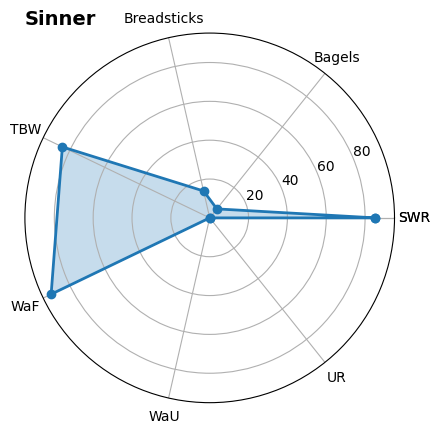

In [ ]:
# Create a spider plot (radar chart) for Sinner's overall statistics
fig = plt.figure()
ax = fig.add_subplot(111, polar=True) # Create a polar plot
ax.plot(angles, sin_stats_for_plot, 'o-', linewidth=2) # Plot the statistics
ax.fill(angles, sin_stats_for_plot, alpha=0.25) # Fill the area under the plot
# Convert numerical stats to strings for the labels
stat_labels = [str(round(stat, 2)) if isinstance(stat, (int, float)) else stat for stat in sin_stats_for_plot]
ax.set_thetagrids(angles * 180/np.pi, labels) # Set the grid labels and angles using the original labels
ax.set_title("Sinner", loc='left', fontsize=14, fontweight='bold') # Set the title of the plot
ax.grid(True) # Enable the grid
# plt.show() # Display the plot
plt.savefig('sinner_stats.png')
# Display the DataFrame containing Sinner's overall statistics
display(sin_stats)

,Player Name,Set_Winning_Rate,Bagels_Delivered,Breadsticks_Delivered,Tiebreaks_Won,Winning_as_Fav,Winning_as_Underdog,Upset_Rate
0,Alcaraz C.,78.873239,3.755869,12.206573,61.538462,91.666667,66.666667,66.666667


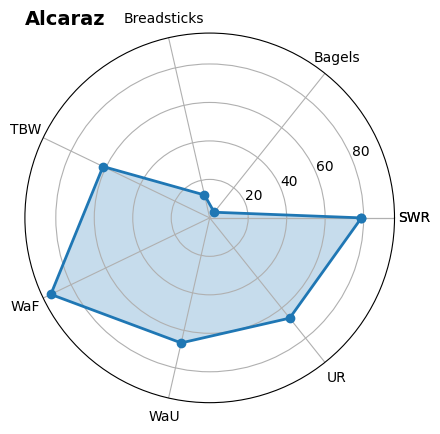

In [ ]:
# Create a spider plot (radar chart) for Alcaraz's overall statistics
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, al_stats_for_plot, 'o-', linewidth=2)
ax.fill(angles, al_stats_for_plot, alpha=0.25)
# Convert numerical stats to strings for the labels
stat_labels = [str(round(stat, 2)) if isinstance(stat, (int, float)) else stat for stat in al_stats_for_plot]
ax.set_thetagrids(angles * 180/np.pi, labels) # Use original labels
ax.set_title("Alcaraz", loc='left', fontsize=14, fontweight='bold')
ax.grid(True)
# plt.show()
plt.savefig('alcaraz_stats.png')
# Display the DataFrame containing Alcaraz's overall statistics
display(al_stats)

,Player Name,Set_Winning_Rate,Bagels_Delivered,Breadsticks_Delivered,Tiebreaks_Won,Winning_as_Fav,Winning_as_Underdog,Upset_Rate
0,Fritz T.,62.427746,0.578035,4.046243,52.173913,74.137931,14.285714,14.285714


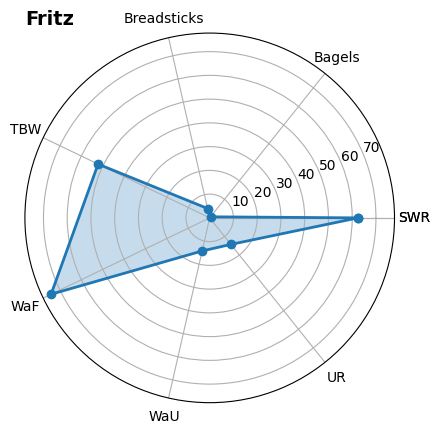

In [ ]:
# Create a spider plot (radar chart) for Fritz's overall statistics
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, fr_stats_for_plot, 'o-', linewidth=2)
ax.fill(angles, fr_stats_for_plot, alpha=0.25)
# Convert numerical stats to strings for the labels
stat_labels = [str(round(stat, 2)) if isinstance(stat, (int, float)) else stat for stat in fr_stats_for_plot]
ax.set_thetagrids(angles * 180/np.pi, labels) # Use original labels
ax.set_title("Fritz", loc='left', fontsize=14, fontweight='bold')
ax.grid(True)
# plt.show()
plt.savefig('fritzr_stats.png')
# Display the DataFrame containing Fritz's overall statistics
display(fr_stats)

,Player Name,Set_Winning_Rate,Bagels_Delivered,Breadsticks_Delivered,Tiebreaks_Won,Winning_as_Fav,Winning_as_Underdog,Upset_Rate
0,Zverev A.,67.1875,0.520833,6.25,61.904762,76.923077,22.222222,22.222222


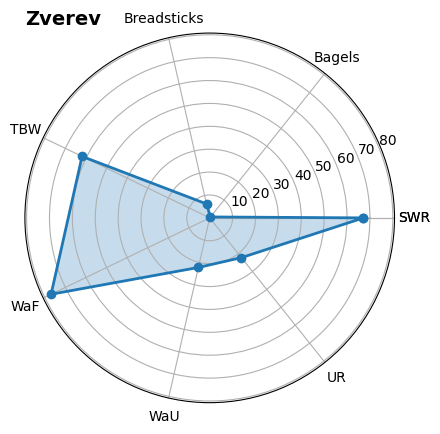

In [ ]:
# Create a spider plot (radar chart) for Zverev's overall statistics
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, zv_stats_for_plot, 'o-', linewidth=2)
ax.fill(angles, zv_stats_for_plot, alpha=0.25)
# Convert numerical stats to strings for the labels
stat_labels = [str(round(stat, 2)) if isinstance(stat, (int, float)) else stat for stat in zv_stats_for_plot]
ax.set_thetagrids(angles * 180/np.pi, labels) # Set the grid labels and angles
ax.set_title("Zverev", loc='left', fontsize=14, fontweight='bold') # Set the title of the plot
ax.grid(True)
# plt.show()
plt.savefig('zverev_stats.png')
# Display the DataFrame containing Zverev's overall statistics
display(zv_stats)

,Player Name,Set_Winning_Rate,Bagels_Delivered,Breadsticks_Delivered,Tiebreaks_Won,Winning_as_Fav,Winning_as_Underdog,Upset_Rate
0,Shelton B.,60.606061,0.0,1.212121,56.25,73.913043,29.411765,29.411765


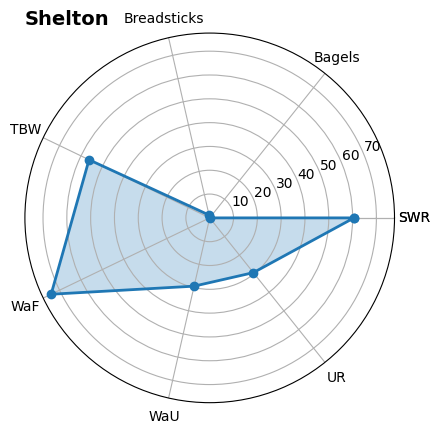

In [ ]:
# Create a spider plot (radar chart) for Shelton's overall statistics
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, shelton_stats_for_plot, 'o-', linewidth=2)
ax.fill(angles, shelton_stats_for_plot, alpha=0.25)
# Convert numerical stats to strings for the labels
stat_labels = [str(round(stat, 2)) if isinstance(stat, (int, float)) else stat for stat in shelton_stats_for_plot]
ax.set_thetagrids(angles * 180/np.pi, labels) # Set the grid labels and angles
ax.set_title("Shelton", loc='left', fontsize=14, fontweight='bold') # Set the title of the plot
ax.grid(True)
# plt.show()
plt.savefig('shelton_stats.png')
# Display the DataFrame containing Shelton's overall statistics
display(shelton_stats)

,Player Name,Set_Winning_Rate,Bagels_Delivered,Breadsticks_Delivered,Tiebreaks_Won,Winning_as_Fav,Winning_as_Underdog,Upset_Rate
0,De Minaur A.,67.032967,3.846154,6.593407,60.869565,76.5625,11.111111,11.111111


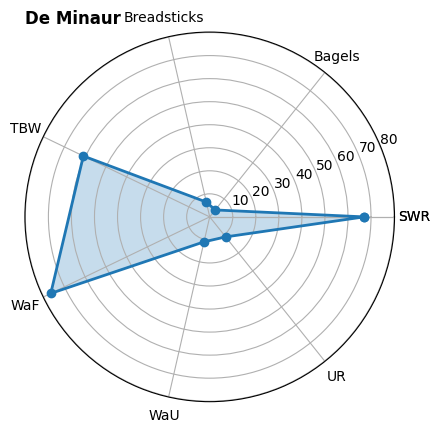

In [ ]:
# Create a spider plot (radar chart) for De Minaur's overall statistics
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, adm_stats_for_plot, 'o-', linewidth=2)
ax.fill(angles, adm_stats_for_plot, alpha=0.25)
# Convert numerical stats to strings for the labels
stat_labels = [str(round(stat, 2)) if isinstance(stat, (int, float)) else stat for stat in adm_stats_for_plot]
ax.set_thetagrids(angles * 180/np.pi, labels) # Set the grid labels and angles
ax.set_title("De Minaur", loc='left', fontsize=12, fontweight='bold') # Set the title of the plot
ax.grid(True)
# plt.show()
plt.savefig('adm_stats.png')
# Display the DataFrame containing De Minaur's overall statistics
display(adm_stats)

,Player Name,Set_Winning_Rate,Bagels_Delivered,Breadsticks_Delivered,Tiebreaks_Won,Winning_as_Fav,Winning_as_Underdog,Upset_Rate
0,Auger-Aliassime F.,61.827957,0.537634,3.225806,69.565217,73.584906,43.75,43.75


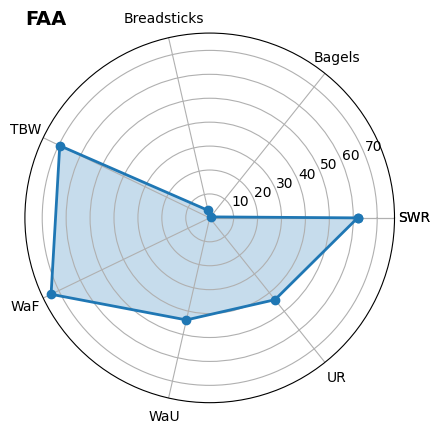

In [ ]:
# Create a spider plot (radar chart) for Auger-Aliassime's overall statistics
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, faa_stats_for_plot, 'o-', linewidth=2)
ax.fill(angles, faa_stats_for_plot, alpha=0.25)
# Convert numerical stats to strings for the labels
stat_labels = [str(round(stat, 2)) if isinstance(stat, (int, float)) else stat for stat in faa_stats_for_plot]
ax.set_thetagrids(angles * 180/np.pi, labels) # Set the grid labels and angles
ax.set_title("FAA", loc='left', fontsize=14, fontweight='bold') # Set the title of the plot
ax.grid(True)
# plt.show()
plt.savefig('faa_stats.png')
# Display the DataFrame containing Auger-Aliassime's overall statistics
display(faa_stats)

,Player Name,Set_Winning_Rate,Bagels_Delivered,Breadsticks_Delivered,Tiebreaks_Won,Winning_as_Fav,Winning_as_Underdog,Upset_Rate
0,Musetti L.,63.687151,3.351955,1.675978,52.0,79.545455,45.0,45.0


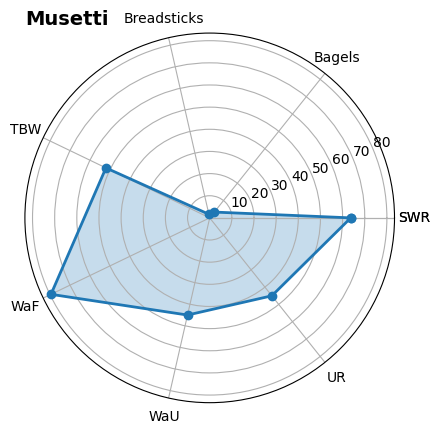

In [ ]:
# Create a spider plot (radar chart) for Musetti's overall statistics
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, musetti_stats_for_plot, 'o-', linewidth=2)
ax.fill(angles, musetti_stats_for_plot, alpha=0.25)
# Convert numerical stats to strings for the labels
stat_labels = [str(round(stat, 2)) if isinstance(stat, (int, float)) else stat for stat in musetti_stats_for_plot]
ax.set_thetagrids(angles * 180/np.pi, labels) # Set the grid labels and angles
ax.set_title("Musetti", loc='left', fontsize=14, fontweight='bold')
ax.grid(True)
# plt.show()
plt.savefig('musetti_stats.png')
# Display the DataFrame containing Musetti's overall statistics
display(musetti_stats)

In [ ]:
all_stats

,Player Name,Set_Winning_Rate,Bagels_Delivered,Breadsticks_Delivered,Tiebreaks_Won,Winning_as_Fav,Winning_as_Underdog,Upset_Rate
0,Sinner J.,85.207101,5.917160,14.201183,84.210526,90.625000,0.000000,0.000000
1,Alcaraz C.,78.873239,3.755869,12.206573,61.538462,91.666667,66.666667,66.666667
2,Fritz T.,62.427746,0.578035,4.046243,52.173913,74.137931,14.285714,14.285714
3,Zverev A.,67.187500,0.520833,6.250000,61.904762,76.923077,22.222222,22.222222
4,Shelton B.,60.606061,0.000000,1.212121,56.250000,73.913043,29.411765,29.411765
5,De Minaur A.,67.032967,3.846154,6.593407,60.869565,76.562500,11.111111,11.111111
6,Auger-Aliassime F.,61.827957,0.537634,3.225806,69.565217,73.584906,43.750000,43.750000
7,Musetti L.,63.687151,3.351955,1.675978,52.000000,79.545455,45.000000,45.000000


In [ ]:
print("### Player Performance Summary Across All Surfaces\n")

for index, row in all_stats.iterrows():
    player_name = row['Player Name']
    set_win_rate = row['Set_Winning_Rate']
    bagels_delivered = row['Bagels_Delivered']
    breadsticks_delivered = row['Breadsticks_Delivered']
    tiebreaks_won = row['Tiebreaks_Won']
    winning_as_fav = row['Winning_as_Fav']
    winning_as_underdog = row['Winning_as_Underdog']

    summary = f"**{player_name}:**\n"
    summary += f"  - Set Winning Rate: {set_win_rate:.2f}%\n"
    summary += f"  - Bagels Delivered: {bagels_delivered:.2f}% (percentage of sets won 6-0)\n"
    summary += f"  - Breadsticks Delivered: {breadsticks_delivered:.2f}% (percentage of sets won 6-1)\n"
    summary += f"  - Tiebreaks Won: {tiebreaks_won:.2f}%\n"
    summary += f"  - Winning as Favorite: {winning_as_fav:.2f}%\n"
    summary += f"  - Winning as Underdog: {winning_as_underdog:.2f}%\n"

    strengths = []
    weaknesses = []

    # Analyze Set Winning Rate
    if set_win_rate >= 80: # Exceptionally high
        strengths.append("Exceptionally high Set Winning Rate")
    elif set_win_rate < 60: # Low
        weaknesses.append("Lower Set Winning Rate")

    # Analyze Bagels and Breadsticks
    if bagels_delivered > 5: # Notable bagels
        strengths.append("High rate of delivering bagels (6-0 sets)")
    if breadsticks_delivered > 10: # Notable breadsticks
        strengths.append("High rate of delivering breadsticks (6-1 sets)")

    # Analyze Tiebreak Win Rate
    if tiebreaks_won >= 70: # High
        strengths.append("Strong Tiebreak performance")
    elif tiebreaks_won < 50 and tiebreaks_won > 0: # Low (if player has played tiebreaks)
        weaknesses.append("Struggles in Tiebreaks")

    # Analyze Winning as Favorite
    if winning_as_fav >= 90: # Very strong
        strengths.append("Highly reliable when favored to win")
    elif winning_as_fav < 70 and winning_as_fav > 0: # Lower reliability (if player has been favorite)
        weaknesses.append("Sometimes struggles when favored to win")

    # Analyze Winning as Underdog
    if winning_as_underdog >= 40: # Significant ability to win as underdog
        strengths.append("Significant ability to win as an underdog (upsets)")
    elif winning_as_underdog < 20 and winning_as_underdog > 0: # Low ability (if player has been underdog)
        weaknesses.append("Lower success rate as an underdog")

    if strengths:
        summary += "  **Strengths:** " + "; ".join(strengths) + "\n"
    if weaknesses:
        summary += "  **Weaknesses:** " + "; ".join(weaknesses) + "\n"

    print(summary)
    print("\n" + "-"*50 + "\n")

### Player Performance Summary Across All Surfaces

**Sinner J.:**
  - Set Winning Rate: 85.21%
  - Bagels Delivered: 5.92% (percentage of sets won 6-0)
  - Breadsticks Delivered: 14.20% (percentage of sets won 6-1)
  - Tiebreaks Won: 84.21%
  - Winning as Favorite: 90.62%
  - Winning as Underdog: 0.00%
  **Strengths:** Exceptionally high Set Winning Rate; High rate of delivering bagels (6-0 sets); High rate of delivering breadsticks (6-1 sets); Strong Tiebreak performance; Highly reliable when favored to win


--------------------------------------------------

**Alcaraz C.:**
  - Set Winning Rate: 78.87%
  - Bagels Delivered: 3.76% (percentage of sets won 6-0)
  - Breadsticks Delivered: 12.21% (percentage of sets won 6-1)
  - Tiebreaks Won: 61.54%
  - Winning as Favorite: 91.67%
  - Winning as Underdog: 66.67%
  **Strengths:** High rate of delivering breadsticks (6-1 sets); Highly reliable when favored to win; Significant ability to win as an underdog (upsets)


---------------------

## ATP Top 8 Players Performance Analysis: Overall and Hard Court Summary

This report provides a concise summary of the performance of the current ATP Top 8 players, both across all surfaces and specifically on hard courts. The analysis focuses on key metrics such as Set Winning Rate (SWR), Bagels (winning a set 6-0), Breadsticks (winning a set 6-1), Tiebreak Win Rate (TBW), Winning as Favorite (WaF), and Winning as Underdog (WaU).

---

### Overall Player Performance Highlights (Across All Surfaces)

| Player Name         | SWR (%) | Bagels (%) | Breadsticks (%) | TBW (%) | WaF (%) | WaU (%) |
|:--------------------|:--------|:-----------|:----------------|:--------|:--------|:--------|
| Sinner J.           | 84.28   | 6.29       | 14.47           | 82.35   | 89.83   | 0.00    |
| Alcaraz C.          | 79.21   | 3.96       | 12.38           | 65.22   | 91.18   | 80.00   |
| Fritz T.            | 63.25   | 0.60       | 4.22            | 52.27   | 75.00   | 16.67   |
| Zverev A.           | 68.28   | 0.54       | 6.45            | 62.50   | 76.56   | 28.57   |
| Shelton B.          | 62.66   | 0.00       | 1.27            | 60.00   | 75.56   | 33.33   |
| De Minaur A.        | 68.79   | 4.05       | 6.94            | 61.90   | 77.78   | 0.00    |
| Auger-Aliassime F.  | 62.71   | 0.56       | 3.39            | 68.18   | 73.08   | 46.15   |
| Musetti L.          | 65.12   | 3.49       | 1.74            | 52.00   | 79.55   | 47.06   |

**Key Insights:**

*   **Jannik Sinner** demonstrates exceptional overall performance with the highest Set Winning Rate (84.28%), significant Bagel and Breadstick delivery, and a dominant Tiebreak Win Rate (82.35%). He is a strong favorite (WaF: 89.83%) and rarely plays as an underdog.
*   **Carlos Alcaraz** also exhibits strong performance with a high SWR (79.21%) and an impressive ability to win as an underdog (80.00%), suggesting resilience and capacity for upsets.
*   **Taylor Fritz**, **Ben Shelton**, and **Felix Auger-Aliassime** show lower SWRs compared to Sinner and Alcaraz, indicating more competitive matches or less dominant performances across all surfaces.
*   **De Minaur** has a solid SWR (68.79%) and a good rate of Bagel/Breadstick delivery, but, like Sinner, he rarely plays or wins as an underdog.
*   **Musetti** and **Auger-Aliassime** stand out for their higher Underdog Win Rates (47.06% and 46.15% respectively) among the lower-ranked players, indicating their potential to upset higher-ranked opponents.
---

### Conclusion

This exploratory data analysis reveals distinct performance profiles for the ATP Top 8 players. **Jannik Sinner** stands out as a dominant force with high set winning and tiebreak success rates. **Carlos Alcaraz** is another top performer, demonstrating exceptional resilience as an underdog. Players like **Ben Shelton** and **Felix Auger-Aliassime** show a clear improvement in certain key metrics, highlighting their potential. Understanding these nuances can provide valuable insights for strategic planning and match predictions.
